In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
# Load your data
df = pd.read_csv('data/fulldata.csv')

# Feature columns as per your request
feature_columns = [
    'WDir(Deg)', 'WSpd(m/s)', 'WindRun(Km)', 'Rain(mm)', 
    'Tdry(C)', 'RH(%)', 'Tmax(C)', 'Tmin(C)', 
    'Pstn(hPa)', 'Sun(Hrs)', 'Rad(MJ/m2)'
]

# Selecting features and target columns
features = df[feature_columns].values
target = df[['Rain(mm)', 'GustSpd(m/s)', 'Pstn(hPa)', 'Sun(Hrs)', 'Rad(MJ/m2)']].values

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Parameters
past = 7  # past 7 days
future = 5  # predict 5 days into the future
sequence_length = past
batch_size = 256
epochs = 10

# Prepare data for time series dataset
def create_dataset(features, target, past, future):
    X, y = [], []
    for i in range(len(features) - past - future + 1):
        X.append(features[i:i+past])
        y.append(target[i+past:i+past+future])
    return np.array(X), np.array(y)

X, y = create_dataset(features_scaled, target, past, future)

# Split into train and validation sets
split_fraction = 0.715
train_split = int(split_fraction * len(X))

X_train, X_val = X[:train_split], X[train_split:]
y_train, y_val = y[:train_split], y[train_split:]

In [5]:
df['Station'][0]

41351

In [10]:
# Create Keras datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 7, 11)
Target shape: (256, 5, 5)


In [12]:
# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(sequence_length, X_train.shape[2])),
    Dense(future)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,797 (22.64 KB)

 Trainable params: 5,797 (22.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.weights.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[es_callback, modelckpt_callback]
)

# Visualization of loss
def visualize_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

visualize_loss(history, 'Training and Validation Loss')

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs defined at (most recent call last):
  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 965, in launch_instance

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code

  File "C:\Users\Iva Wright\AppData\Local\Temp\ipykernel_12636\1355273511.py", line 10, in <cell line: 10>

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 318, in fit

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\Iva Wright\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 70, in train_step

Incompatible shapes: [256,5,5] vs. [256,5]
	 [[{{node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_5006]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


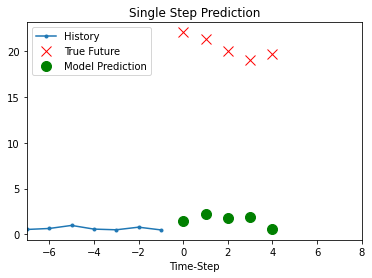

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


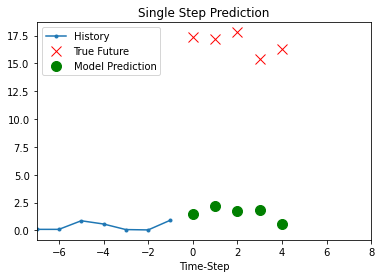

In [10]:
# Function to plot predictions
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future_steps = list(range(delta))

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i == 1:  # True Future
            plt.plot(future_steps, val, marker[i], markersize=10, label=labels[i])
        elif i == 2:  # Model Prediction
            plt.plot(future_steps, val, marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, val.flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future_steps[-1] * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

# Predict and plot
for x, y in val_dataset.take(5):
    x_np = x.numpy()
    y_np = y.numpy()
    y_pred = model.predict(x_np)
    show_plot([x_np[0][:, 0], y_np[0], y_pred[0]], future, "Single Step Prediction")